In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (mean_squared_error, accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)
import numpy as np
import pandas as pd
import ast
import seaborn as sns

# Predicting jobs
The NYU centre for data science hosted a project exposition where gunning data scientists could come up and present analytical projects in front of industry professionals and fellow students. Propelled by our frustrations with the internship job search, a friend and I attempted to develop a predictor that could determine whether a user would be accepted into a job based on a list of skills a user provided. And despite only being able to produce an SVM model with 60% accuracy, we walked away from the expo with constructive feedback on how we could improve moving forward. *For my Data Bootcamp final*, I decided to build on the job predictor. Note that for time's sake, *this notebook will only be using a sample* of the actual dataset with the sample only containing four thousand datapoints. 

### Footnotes
The dataset was already mostly preprocessed, so to shorten this notebook that will mostly be left out: Numeric NaN values were replaced with zeroes, Qualitative NaN values were replaced on a case by case scenario, duplicate jobs were merged to form lists in certain columns. The original models can also be uploaded for reference, but everything here on out will be completely new work taking from the models and concepts learnt in class.

The threshold value for the classifier (for now) will be whether an applicant gets above or below the 75th percentile in salary: getting above that percentile would mean that you get the job. So really this is a glorified income predictor.

## Critique one: Better data preparation
There were many flaws in the initial data loading and preparation. For this reason, data cleaning was redone but with a more refined approach that involved, for the most part, much cleaner groupby functions that merged skills and industries into lists for every job. The resulting dataframe went from several million datapoints to a few hundred thousand with 93 columns.

### Cutting out columns
While being a potentially shortsighted approach, features with a very low linear correlation (<0.1) were dropped on the basis that they were unnecessary to keep and to reduce dimensionality. My end goal is to conduct dimensionality reduction and feature engineering with a PCA.

Jobs with either a maximum or minimum salary do not have a median salary attached and vice versa. Let's take a look and see whether there is any discernible difference between those jobs.

In [2]:
data = pd.read_csv('../Cleaning/Cleaned_mini_dataset_for_bootcamp.csv')

In [3]:
median_only_jobs = data[(data['med_salary_x'].notna()) & (data['max_salary_x'].isna()) & (data['min_salary_x'].isna())]
max_min_salary_jobs = data[(data['max_salary_x'].notna()) | (data['min_salary_x'].notna())]
median_stats = median_only_jobs.describe(include='all')
max_min_stats = max_min_salary_jobs.describe(include='all')

Significantly more jobs with max/min pay information, and these jobs are more diverse and tend to involve larger companies with annual instead of hourly pay periods.
Hourly vs. Yearly Pay: Median-only jobs are typically hourly roles, while max/min salary jobs tend to be yearly roles.
Industry and Size: Median-only jobs are more focused on smaller companies and specific sectors, while max/min salary jobs span a wider range of industries and include larger companies.

For these reasons, I am going to cut out any job with median salary information as the initial predictor was catered towards students looking for white-collared jobs. I will also hand-pick meaningless columns to drop, as many columns are present due to the initial merging of datasets to generate this. Anything with the x suffix came from company data, y from job specific.

In [4]:
# Drop rows where max_salary_x is null 
data = data.dropna(subset=['max_salary_x']).reset_index(drop=True)
data.dropna(axis=1,how='all', inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    2299 non-null   int64  
 1   company_name_x                2296 non-null   object 
 2   title_x                       2299 non-null   object 
 3   description_x_x               2299 non-null   object 
 4   max_salary_x                  2299 non-null   float64
 5   pay_period_x                  2299 non-null   object 
 6   location_x                    2299 non-null   object 
 7   min_salary_x                  2299 non-null   float64
 8   formatted_work_type_x         2299 non-null   object 
 9   remote_allowed_x              2299 non-null   object 
 10  job_posting_url_x             2299 non-null   object 
 11  application_url_x             2299 non-null   object 
 12  application_type_x            2299 non-null   object 
 13  clo

In [6]:
columns_to_drop = ['industry_id', 'currency_y', 'skill_abr', 'url_x', 'address_x', 'name_x', 'job_posting_url_x', 'location_x', 'skills_desc_x', 'posting_domain_x', 'currency_x', 'zip_code_y_x', 'job_posting_url_y', 'application_url_y', 'application_type_y', 'posting_domain_y', 'skills_desc_y', 'work_type_y', 'inferred_y', 'company_size_y', 'address_y', 'url_y', 'application_url_x', 'description_x_y', 'name_y', 'description_y_y', 'zip_code_y_y', 'Unnamed: 0', 'formatted_experience_level_y', 'country_y', 'location_y', 'state_y', 'company_name_y', 'max_salary_x', 'min_salary_x', 'pay_period_x', 'remote_allowed_x', 'closed_time_x', 'sponsored_x', 'compensation_type_x', 'type_x', 'city_x', 'employee_count_x', 'follower_count_x', 'industry_name_x', 'skill_name_x', 'formatted_work_type_x', 'type_x', 'title_y']
data.drop(columns_to_drop, axis=1, inplace=True)

In [7]:
# Rename columns to be more readable
new_column_names = {
    'company_name_x': 'Company Name',
    'title_x': 'Job Title',
    'description_x_x': 'Job Description',
    'formatted_work_type_x': 'Work Type',
    'application_type_x': 'Application Type',
    'formatted_experience_level_x': 'Experience Level',
    'work_type_x': 'Work Category',
    'inferred_x': 'Inferred Data',
    'description_y_x': 'Company Description',
    'company_size_x': 'Company Size',
    'state_x': 'State',
    'country_x': 'Country',
    'title_y': 'Alt Job Title',
    'max_salary_y': 'Max Salary',
    'pay_period_y': 'Pay Period',
    'min_salary_y': 'Min Salary',
    'formatted_work_type_y': 'Alt Work Type',
    'remote_allowed_y': 'Remote Allowed',
    'closed_time_y': 'Closed Time',
    'sponsored_y': 'Sponsored',
    'compensation_type_y': 'Compensation Type',
    'type_y': 'Benefits',
    'city_y': 'City',
    'employee_count_y': 'Employee Count',
    'follower_count_y': 'Follower Count',
    'skill_name_y': 'Skills',
    'industry_name_y': 'Industries'
}

# Rename columns in the DataFrame
data.rename(columns=new_column_names, inplace=True)

# Dropping internships because of sparsity in this dataset
data = data[~data['Experience Level'].str.contains('Internship', case=False, na=False)]
data = data[~data['Experience Level'].str.contains('Not Specified', case=False, na=False)]

In [8]:
data.head(20)

,Company Name,Job Title,Job Description,Application Type,Experience Level,Work Category,Inferred Data,Company Description,Company Size,State,...,Remote Allowed,Closed Time,Sponsored,Compensation Type,Benefits,City,Employee Count,Follower Count,Skills,Industries
0,techolution,Robotics Manufacturing engineer,We are seeking a skilled Robotics Manufacturin...,ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,Techolution is a leading innovation consulting...,3.0,New York,...,Unknown,Still Open,0,BASE_SALARY,401(k),New York,452.0,299691.0,['Production'],['Medical Equipment Manufacturing']
1,LHH,Senior Network Engineer (RELO AVALIBLE),LHH Technology is seeking a Senior Network Eng...,ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,Welcome to LHH!\n\nWe're a global leader in HR...,7.0,Florida,...,Unknown,Still Open,0,BASE_SALARY,Disability insurance,Jacksonville,13663.0,2478006.0,['Information Technology'],['IT Services and IT Consulting']
2,CDW,Principal Engineer,The Principal Consultant is a client facing te...,ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,"At CDW, our experts partner with you to build ...",7.0,IL,...,1.0,Still Open,0,BASE_SALARY,Disability insurance,Vernon Hills,17652.0,233653.0,"['Engineering', 'Consulting', 'Information Tec...","['Business Consulting and Services', 'IT Servi..."
3,Calculated Hire,Associate Account Executive,"Launched in 2000, Eight Eleven Group committed...",ComplexOnsiteApply,Entry level,FULL_TIME,0.0,Talent Delivery. Modernized.\n\nHere at Calcul...,2.0,IN,...,Unknown,Still Open,0,BASE_SALARY,Dental insurance,Indianapolis,108.0,208604.0,"['Business Development', 'Sales']","['Staffing and Recruiting', 'Business Consulti..."
5,techolution,Sr Robotics Manufacturing Engineer,Techolution is looking for a smart and dynamic...,ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,Techolution is a leading innovation consulting...,3.0,New York,...,Unknown,Still Open,0,BASE_SALARY,Medical insurance,New York,453.0,300077.0,"['Manufacturing', 'Production', 'Engineering']","['Warehousing and Storage', 'Medical Equipment..."
6,LHH,Billing Analyst,Do you live in San Diego and have interest in ...,SimpleOnsiteApply,Associate,FULL_TIME,0.0,Welcome to LHH!\n\nWe're a global leader in HR...,7.0,Florida,...,Unknown,Still Open,0,BASE_SALARY,Medical insurance,Jacksonville,13651.0,2476415.0,"['Accounting/Auditing', 'Finance', 'Analyst']","['Services for Renewable Energy', 'Professiona..."
7,T-Mobile,"Manager, Cybersecurity Engineering",Be unstoppable with us!\n\nT-Mobile is synonym...,OffsiteApply,Mid-Senior level,FULL_TIME,1.0,"T-Mobile US, Inc. (NASDAQ: TMUS) is America’s ...",7.0,WA,...,Unknown,Still Open,0,BASE_SALARY,Disability insurance,Bellevue,86861.0,539291.0,['Information Technology'],['Telecommunications']
8,Russell Tobin,Human Resources Business Partner,Russell Tobin & Associates is currently seekin...,ComplexOnsiteApply,Mid-Senior level,CONTRACT,1.0,Bring Top Talent With Your Company With Russel...,3.0,New York,...,Unknown,Still Open,0,BASE_SALARY,401(k),New York,597.0,614163.0,"['Human Resources', 'Legal']","['Hospitals and Health Care', 'Public Health']"
9,Insight Global,Software Engineering Supervisor,"A client in Los Angeles, CA are seeking a skil...",ComplexOnsiteApply,Mid-Senior level,FULL_TIME,0.0,Insight Global is an international staffing an...,5.0,Georgia,...,Unknown,Still Open,0,BASE_SALARY,Paid maternity leave,Atlanta,14134.0,2424499.0,"['Management', 'Engineering', 'Information Tec...","['Software Development', 'Hospitals and Health..."
10,Amazon,"Production Manager, Amazon Publishing Global",Description\n\nAmazon Publishing is looking fo...,OffsiteApply,Mid-Senior level,FULL_TIME,Unknown,Amazon is guided by four principles: customer ...,7.0,WA,...,Unknown,Still Open,0,BASE_SALARY,Not Specified,Seattle,749112.0,30761659.0,['Management'],['Software Development']


In [9]:
pay_periods = data['Pay Period'].unique()
print(pay_periods)

['YEARLY' 'HOURLY' 'MONTHLY' 'WEEKLY']


In [10]:
# Keeping yearly jobs as these are more representative of relevant jobs to us students.
data = data[data['Pay Period'] == 'YEARLY']

## Critique two: Better EDA
Now that the columns have been tidied up, we learned that it's best to develop a more intimate EDA. Not only will this allow us to gauge the underlying relationships, but it will ultimately allow us to build a better model.


As was already alluded to earlier, we are using salaries as a stand-in for whether an applicant is accepted into a job or not by assuming that salaries are a good indication of quality. Despite being a simplistic approach, it was our best alternative accounting for the fact that LinkedIn does not provide recruiting data.

From the previous analysis, I remember that the data was very skewed, so I will be taking the interquartile range to remove outliers.

In [11]:
data = data[data['Country'] == 'US']

Q1 = data['Max Salary'].quantile(0.25)
Q3 = data['Max Salary'].quantile(0.75)
IQR = Q3 - Q1

# Filter based on the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['Max Salary'] >= 10000) & (data['Max Salary'] <= upper_bound)]

# Turning Skills and Industries rows back into lists
data['Skills'] = data['Skills'].apply(lambda x: eval(x) if isinstance(x, str) else [])
data['Industries'] = data['Industries'].apply(lambda x: eval(x) if isinstance(x, str) else [])

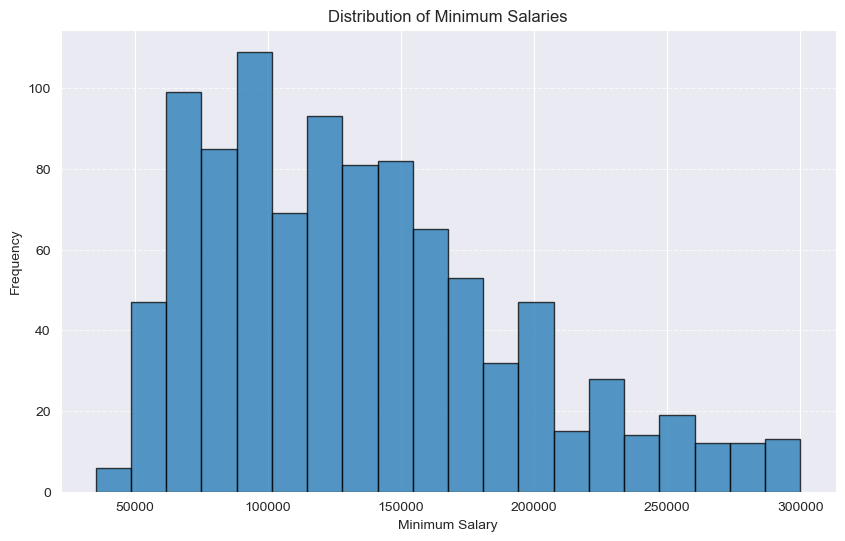

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(data['Max Salary'], bins=20, alpha=0.75, edgecolor='black')
plt.title('Distribution of Minimum Salaries')
plt.xlabel('Minimum Salary')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Salaries will be the target variable in the classifier so it would make sense to look at its distribution. Whilst it is not very evident here, the actual distribution is far more normal with a slight right skew.

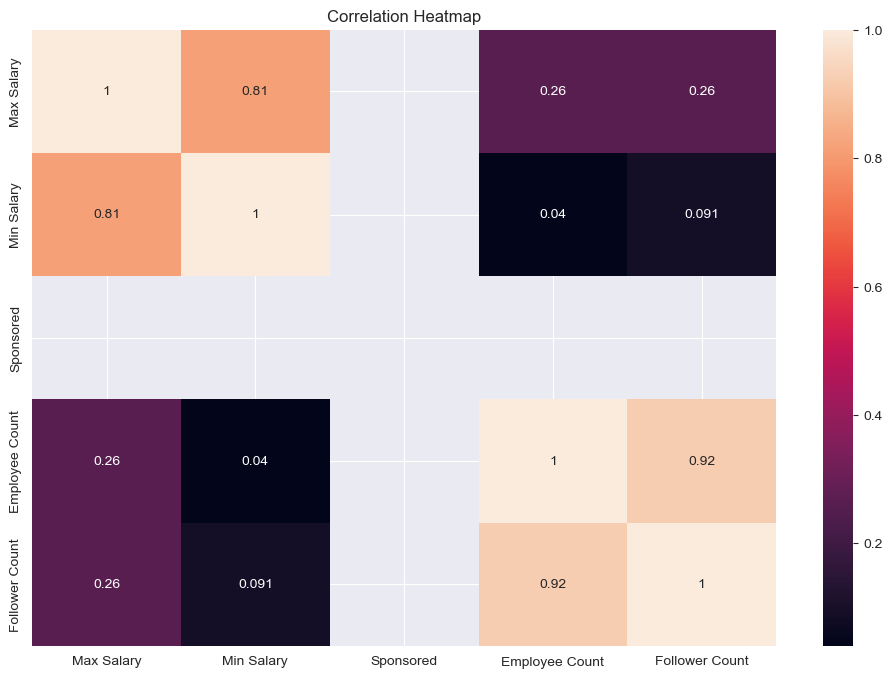

In [13]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [14]:
# Upon further inspection, the originL dataset has extremely few sponsored job postings. So for now I will remove this column
data.drop('Sponsored', axis=1, inplace=True)

Other than the fact that the sponsored column only contains one value, company employee count, Linkedin follower count and minimum salaries all have positive correlations with max salary. Keep in mind that employee count and follower counts are very heavily correlated, and that minimum salaries are less correlated with the other variables.

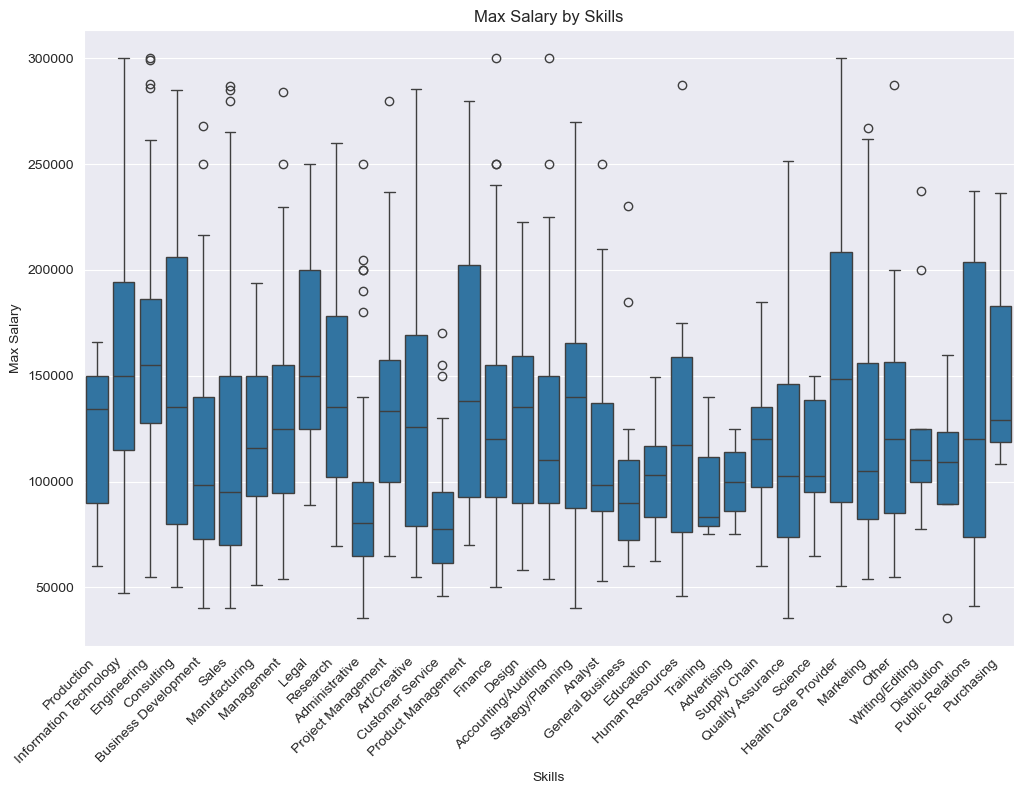

In [15]:
# Define plotting function for lists
def plot_list_column_vs_salary(column, title):
    exploded = data.explode(column).reset_index(drop=True)
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=exploded, x=column, y='Max Salary')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Max Salary by {title}')
    plt.show()

# Plot Skills vs. Max Salary
plot_list_column_vs_salary('Skills', 'Skills')

Here we have the distribution of maximum salaries for each of the 35 unique skills in the dataset. It can be seen that some skills are more conducive to higher salaries than others, where some skills like 'administrative' or 'customer service' have much lower median salaries.

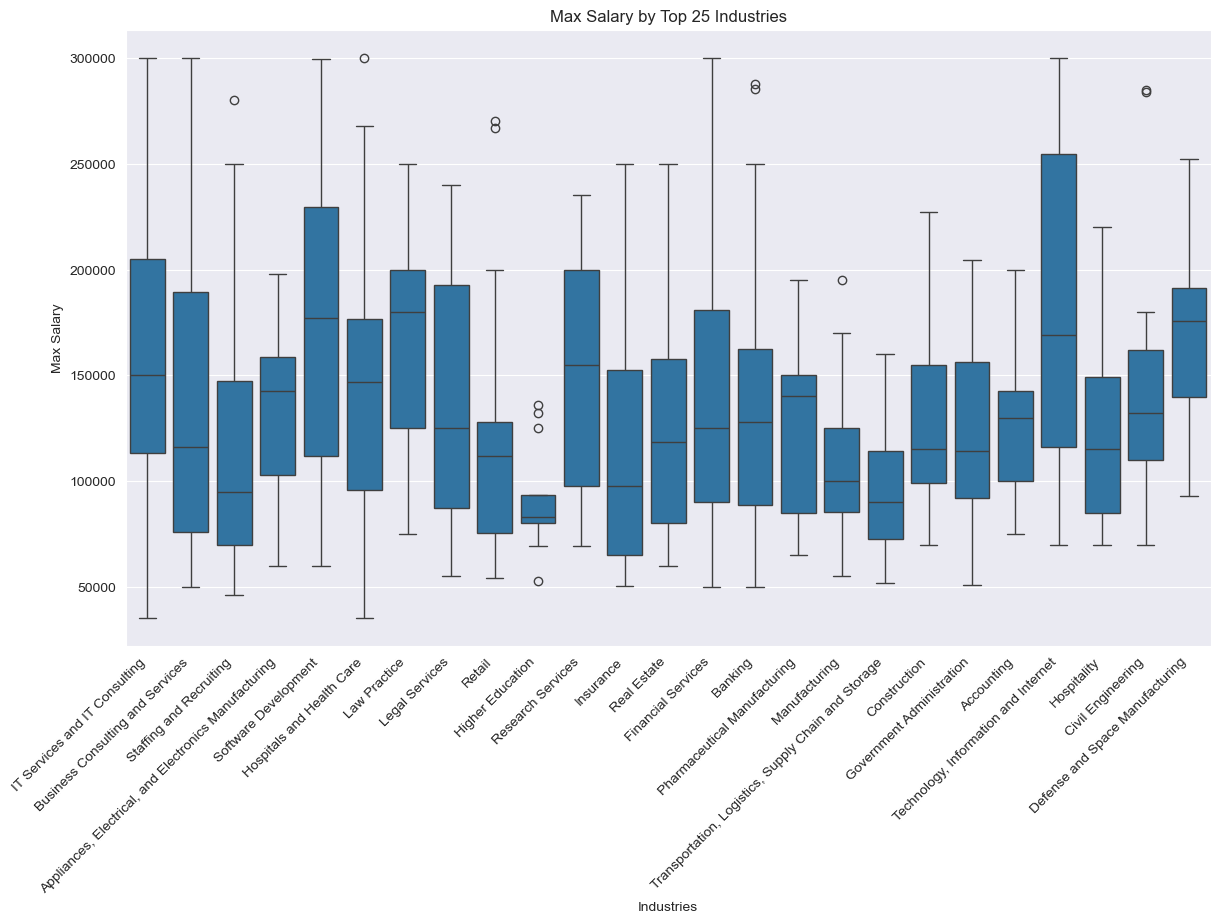

In [16]:
# Top 10 industries by occurrence
top_industries = data.explode('Industries')['Industries'].value_counts().head(25).index

# Filter only top industries
filtered_data = data.explode('Industries')
filtered_data = filtered_data[filtered_data['Industries'].isin(top_industries)]

# Replot with filtered data
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_data, x='Industries', y='Max Salary')
plt.xticks(rotation=45, ha='right')
plt.title('Max Salary by Top 25 Industries')
plt.show()

There are many more unique industries than skills because skills were inferred from job descriptions and industries were explicitly listed on the postings, so it is something to do with the way data was initially scraped. That said, we see that there is again a wide distribution of salaries by industry with 'Entertainment Providers' for example earning much more than other industries like 'Manufacturing'.

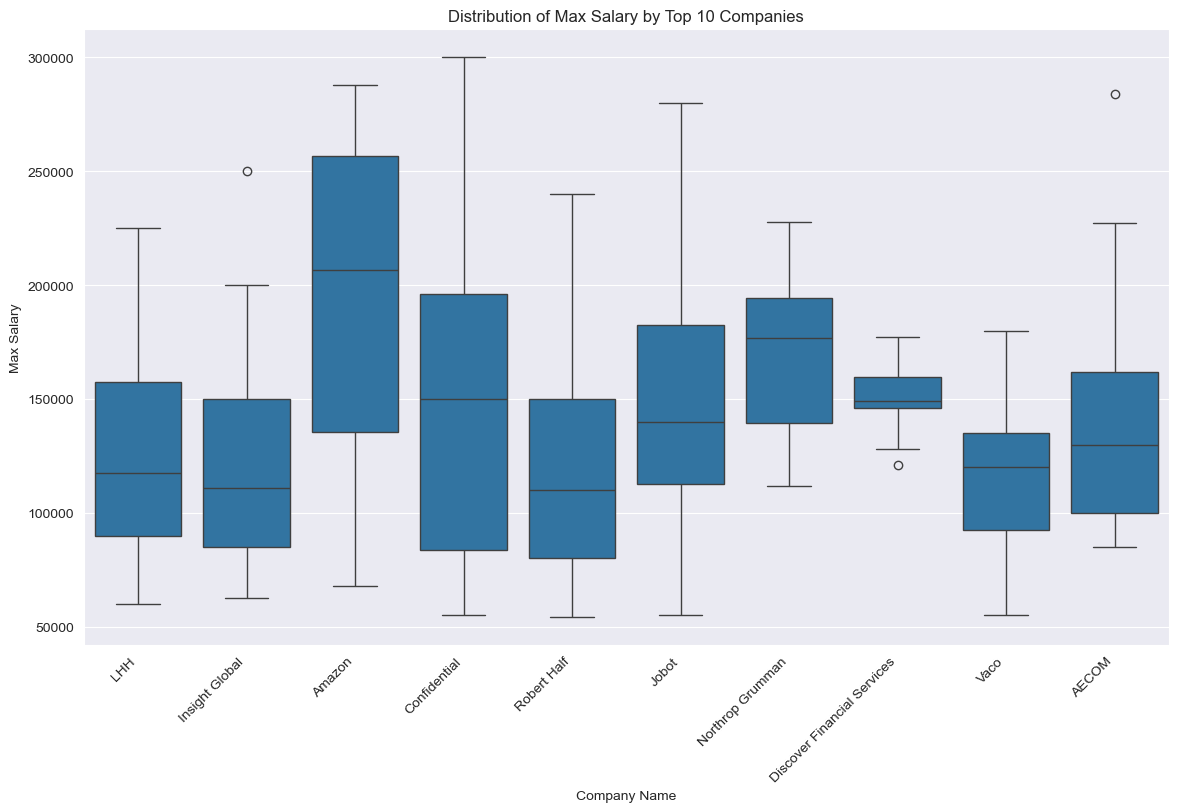

In [17]:
# Identify the top 10 most frequently occurring companies
top_10_companies = data['Company Name'].value_counts().head(10).index

# Filter the data to include only the top 10 companies
top_companies_data = data[data['Company Name'].isin(top_10_companies)]

# Plot the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=top_companies_data, x='Company Name', y='Max Salary')

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Max Salary by Top 10 Companies')
plt.xlabel('Company Name')
plt.ylabel('Max Salary')
plt.show()

Amazon being the huge company it is stands as an outlier in company size, so I ended up plotting boxplots instead.

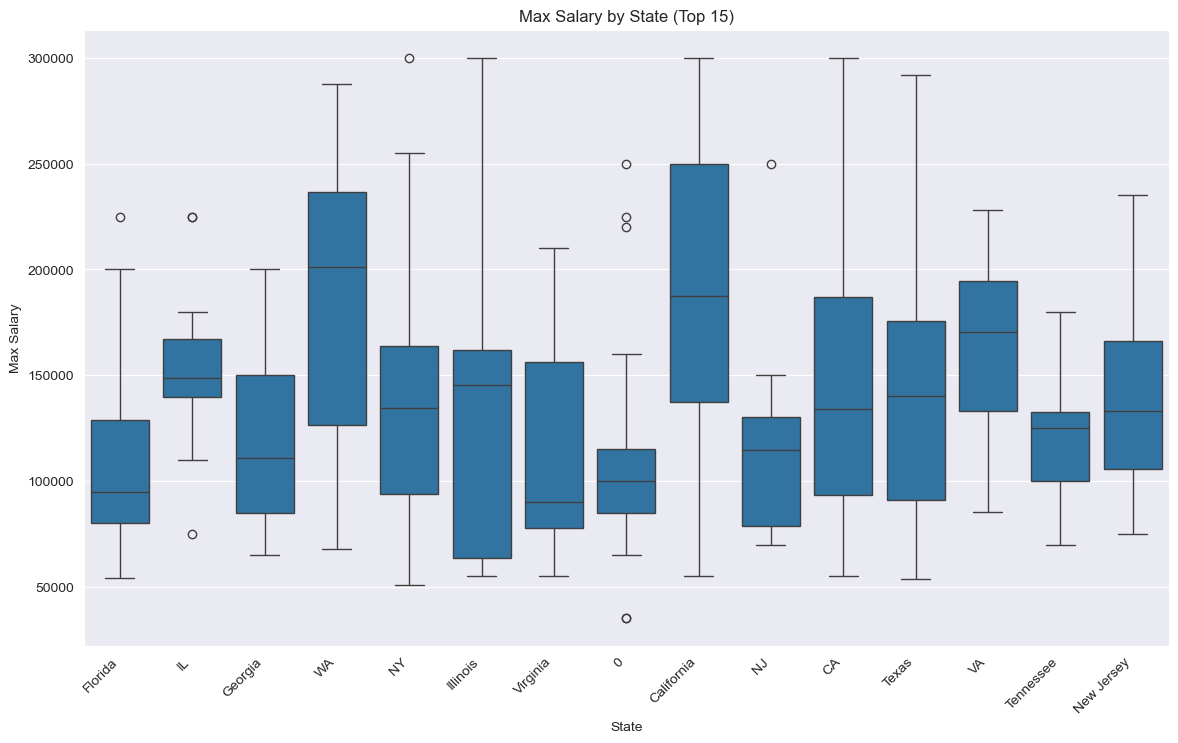

In [18]:
top_states = filtered_data['State'].value_counts().head(15).index
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_data[filtered_data['State'].isin(top_states)], 
            x='State', y='Max Salary')
plt.xticks(rotation=45, ha='right')
plt.title('Max Salary by State (Top 15)')
plt.show()

Remember to account for different naming conventions e.g. New York vs NY.
Rememember that in dataset generation NaN states were filled with 0 hence that label.

In [19]:
# Checking column names
data.columns

Index(['Company Name', 'Job Title', 'Job Description', 'Application Type',
       'Experience Level', 'Work Category', 'Inferred Data',
       'Company Description', 'Company Size', 'State', 'Country', 'Max Salary',
       'Pay Period', 'Min Salary', 'Alt Work Type', 'Remote Allowed',
       'Closed Time', 'Compensation Type', 'Benefits', 'City',
       'Employee Count', 'Follower Count', 'Skills', 'Industries'],
      dtype='object')

One huge realisation my teammate and I made after conducting linear analysis was that many skills were inferred with higher level jobs. For example, executive IT jobs would no longer have IT have a listed skill primarily because it is already assumed, which would explain many of the negative coefficients we were extracting. Below are some plots to try and discern any relationship we could try and control for.

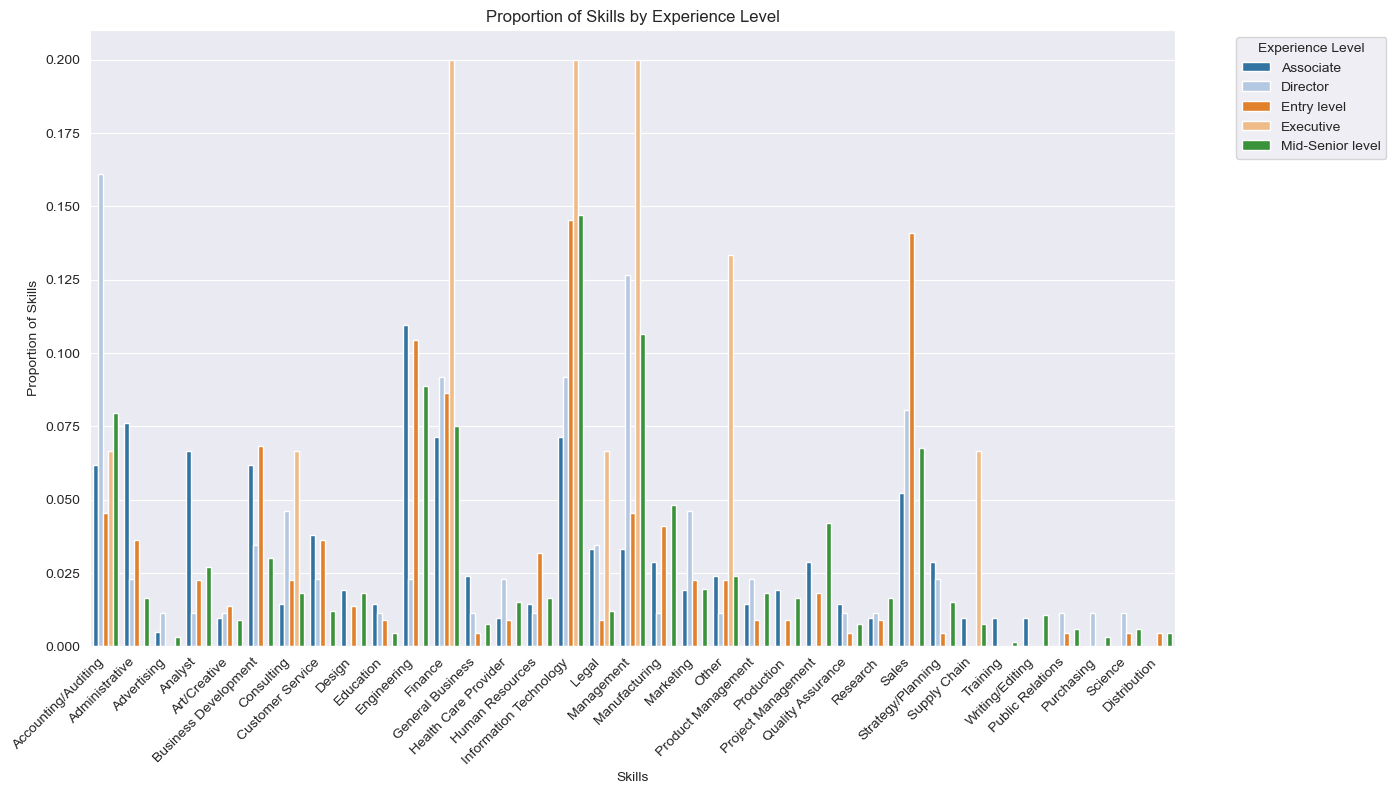

In [20]:
# Explode the 'Skills' column to create one skill per row
exploded_skills = data.explode('Skills').dropna(subset=['Skills'])

# Calculate proportions of skills by Experience Level
skill_counts = exploded_skills.groupby(['Experience Level', 'Skills']).size().reset_index(name='Count')
skill_totals = skill_counts.groupby('Experience Level')['Count'].transform('sum')
skill_counts['Proportion'] = skill_counts['Count'] / skill_totals

# Plot proportional distribution
plt.figure(figsize=(14, 8))
sns.barplot(data=skill_counts, x='Skills', y='Proportion', hue='Experience Level', palette='tab20')

plt.xticks(rotation=45, ha='right')
plt.title('Proportion of Skills by Experience Level')
plt.ylabel('Proportion of Skills')
plt.xlabel('Skills')
plt.legend(title='Experience Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

More executive roles tend to showcase less skills to a greater extent – skills like finance, management, IT and supply chain skills. But other than that it is hard to tell whether there is any real difference in skills required across experience levels.

Note that there are only 35 unique skills in the entire dataset. 